## Postavka zadatka

Date su **dve datoteke** koje sadrže popis **događaja registrovanih na kontrolnim uređajima za pristup** na Matematičkom fakultetu. Podaci su prošli kroz svojevrsnu anonimizaciju. Kraća datoteka sadrži dvodnevna očitavanja, a duža sedmodnevna. Obe su izvezene kao events fajlovi – tabele događaja.

Prvi zadatak obuhvata dve povezane celine. S jedne strane, potrebno je adekvatno opisati date podatke, dakle izvršiti **deskriptivnu**, **frekvencijsku**, **eksplorativnu** i povezane analize. S druge strane, potrebno je uporediti dobijene datoteke, dakle izvršiti **komparativnu** odnosno **diskriminativnu** analizu, te utvrditi koja od njih predstavlja normalne okolnosti na sistemu, a na kojoj se očitava potencijalni neovlašćeni pristup i/ili napad. Oba se rade istovremeno.

Ovo je samo kratak uvod, a na kraju teksta je dat detaljan zaključak, koji redom sumira sve dobijene rezultate, kao i primenjene metode i tehnike.

## Učitavanje podataka

Kako je već napomenuto, podaci su izvezeni u formi **tabele događaja**. Ovaj format započinje **zaglavljem** sa metapodacima koji opisuju tabelu koja sledi, nakon čega se nalazi i sama tabela, u uobičajenom formatu **zapetama razdvojenih vrednosti** (*CSV*). Prvi red zaglavlja govori o tome da je u pitanju events file, a drugi sadrži tačno vreme generisanja izveštaja. Slede redovi koji, jedan za drugim, opisuju kolone tabele. Ukupno je 38 atributa, odnosno ID + 37, ali ih je samo devet tj. osam (veća datoteka ne sadrži ID) izdvojeno prilikom generisanja izveštaja. Za rad je zgodno koristiti module *numpy* i *pandas*.

In [1]:
import numpy as np
import pandas as pd

Sledi funkcija za učitavanje podataka. Kako je ručno pročitano iz distribuiranih fajlova, svaki događaj opisan je jedinstvenim identifikatorom (*Unique event ID*), datumom (*Date*), vremenom (*Time*), identifikatorom (*User ID*) i imenom korisnika (*User name*), identifikatorom (*Access point ID*) i imenom pristupne tačke (*Access point name*), zonom (*Zone*) i imenom grupe (*Group name*). Jedinstveni identifikator je indeksna kolona, a izostavljen je u većem fajlu, pa se za njega pravi podrazumevani brojčani indeks. Isključeno je prvih 40 redova, koji čine zaglavlje. Datumi su spojeni u jedinstvenu kolonu (*Timestamp*). Valja napomenuti i da su kolone malo izmešane, pa se tako npr. u zaglavlju zapravo prvo nalaze svi identifikatori, pa imena, dok su podaci u tabelama dati naizmenično.

In [2]:
kolone = ['Event ID',
          'Date', 'Time',
          'User ID', 'User name',
          'Access point ID', 'Access point name',
          'Zone', 'Group name']

def učitaj(naziv, index=True):
    return pd.read_csv(naziv,
                       index_col=kolone[0] if index else None,
                       skiprows=40,
                       names=kolone if index else kolone[1:],
                       parse_dates={'Timestamp': ['Date', 'Time']})

**Mala** datoteka ima **5.899** unosa od 25. februara 2019. do 26. februara 2019.

In [3]:
mali = učitaj('AnonimiziraniPodaci2526.csv')
#mali

**Velika** datoteka ima **18.129** unosa od 18. februara 2019. do 24. februara 2019.

In [4]:
veliki = učitaj('AnonimiziraniPodaciI1824.csv', False)
#veliki

## Pregled kolona

Nakon opšteg opisa, korisno je utvrditi dodatne osobine atributa. Za to se za početak mogu spojiti svi podaci.

In [5]:
spojeni = pd.concat((veliki, mali))
#spojeni

Spojeni podaci se profajliraju pomoću modula **Pandas Profiling**, koji vrši izuzetno detaljnu eksplorativnu analizu. Osim što su detaljni, rezultati analize su predstavljeni u vizuelno vrlo lepoj i interaktivnoj formi. U nastavku su izvojeni najvažniji rezultati.

**Opšti pregled**:
* Skoro svaka peta ćelija je nedostajuća (prazna).
* Očekivano, zbog jedinstvenih indeksa nema dupliranih unosa.
 * Situacija je drugačija kada se indeksi zanemare.
* Numerička su 3, datumski 1, a kategorička 4 atributa.

**Frekvencijska analiza**:
* Očekivano, indeks je jedinstven.
 * Nije uticalo to što veliki fajl nema indekse.
 * Ovo, inače, verovatno znači da je velikim manipulisano.
* Tek svaki drugi timestamp je poseban (*distinct*).
 * Ovo onemogućava posmatranje skupa kao prave vremenske serije.
 * Pravim vremenskim serijama je vreme indeks, dakle jedinstveno.
* Svaki drugi nenedostajući unos kontrolnog je tipa.
* Većina identifikatora pristupne tačke je jednocifrena.
* Preko četvrtine unosa je u podrazumevanoj (*default*) zoni.
* Administratori su najčešća nenedostajuća grupa.

**Povezanost atributa**:
* Identifikatori su u jakoj vezi sa imenima.
 * Identifikatori jednoznačno određuju imena.
* Pristupne tačke su u jakoj vezi sa zonama.
 * Pristupna tačka ima fiksno mesto u zgradi.
* Korisnici su u određenoj vezi sa pristupnim tačkama.
 * Isti korisnici često pristupaju istim tačkama.

**Nedostajuće vrednosti**:
* Dve trećine unosa nema pridruženo korisničko ime.
* Malo više od svakog sedmog unosa sadrži ime grupe.
* Sveukupno 3 od 5 unosa nema uneto nijedno ime.
* Sem te dve, ostale kolone su u potpunosti popunjene.

In [6]:
from pandas_profiling import ProfileReport

#ProfileReport(spojeni, progress_bar=False)
ProfileReport(spojeni, sensitive=True, progress_bar=False)

Iako jedinstvenost indeksa čini da je svaki unos jedinstven, to nije slučaj kada se indeksi odbace, te postoje **duplikati**.

In [7]:
print(f'Duplikati u malom: {sum(mali.duplicated())}')
print(f'Duplikati u velikom: {sum(veliki.duplicated())}')
print(f'Duplikati u spojenom: {sum(spojeni.duplicated())}')

Duplikati u malom: 1332
Duplikati u velikom: 4351
Duplikati u spojenom: 5683


Kao što je već pomenuto, postoji veza između **korisnika i pristupnih tačaka**, pa se i ona može vizuelizovati. Jednostavnosti radi, prikaz je ograničen na malu datoteku, a odbačeni su kontrolni i anonimni unosi, odnosno događaji bez poznatog pokretača. Kako bi prikaz bio pregledan, identifikatori su zamenjeni svojim rangom u sortiranom nizu. Metod vizuelizacije je **saće (šestouglovi)**. Primećuje se da stvarno neki korisnici više koriste određene pristupne tačke od drugih.

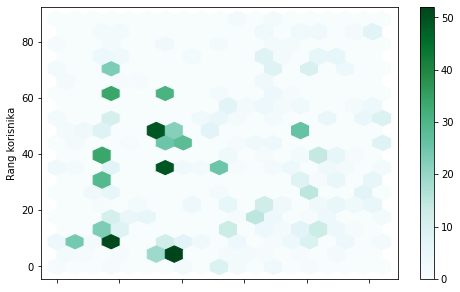

In [8]:
def rangirajID(ser):
    ser = ser.unique()
    rang = np.argsort(ser)
    mapa = zip(ser, rang)
    return dict(mapa)

saće = mali[mali['User ID'] < 500]
saće = saće[saće['User ID'] > 0]

mapa = rangirajID(saće['User ID'])
saće['User ID'] = saće['User ID'].map(lambda ID: mapa[ID])

mapa = rangirajID(saće['Access point ID'])
saće['Access point ID'] = saće['Access point ID'].map(lambda ID: mapa[ID])

_ = saće.plot.hexbin(x='Access point ID', y='User ID',
                     ylabel='Rang korisnika',
                     gridsize=18, figsize=(8, 5))

## Funkcionalne zavisnosti

Zanimljivo je proveriti pretpostavljene **funkcionalne zavisnosti**. Očekivano bi bilo:
* {User ID} $\rightarrow$ {User name},
* {User ID} $\rightarrow$ {Group name},
* {Access point ID} $\rightarrow$ {Access point name},
* {Access point ID} $\rightarrow$ {Zone}.

Ukoliko bi se to ispostavilo kao istinito, bili bi dovoljni samo timestamp i identifikatori, a da se pritom u potpunosti zadrži znanje o skupu, bez suštinskog gubitka informacija. I dalje bi bilo poznato ko je tačno, kad i šta uradio. Gube se jedino imena, mada su ona svakako anonimizirana do neprepoznatljivosti.

U nastavku je funkcija koja ispituje pretpostavljene zavisnosti i obaveštava ukoliko su narušene. Pritom čuva **mapu** koja prvi argument (konkretno identifikatore korisnika ili pristupnih tačaka) preslikava u drugi argument (konkretno njihovo ime ili zonu), indeks prvog događaja čiji su glavni akteri, kao i broj događaja pridruženih prvom argumentu. Metoda je, međutim, ne vraća, pošto je mapa glomazna za prikaz, ali bi se lako mogla doraditi npr. tako da je sortira po ključevima i sačuva u *JSON* formatu ili, još bolje, napravi novu tabelu, koja bi normalizovala ulazni skup u skladu sa načelima relacionih baza podataka.

In [9]:
def jednaki(x, y):
    return x == y or pd.isnull(x) and pd.isnull(y)

def zavisnost(df, col1, col2):
    mapa = {}
    ok = True
    
    for ind, unos in df.iterrows():
        key = unos[col1]
        val = unos[col2]
        
        if not pd.isnull(val):
            und = val.find('_T')
            if und != -1:
                val = val[:und]

            ast = val.find('***')
            if ast != -1:
                val = val[:ast]
        
        if key in mapa:
            mapa[key]['broj'] += 1
            
            if not jednaki(val, mapa[key]['ime']):
                ok = False
                
                print('Promena!')
                print(f'Prethodno ({mapa[key]["ind"]}): {key} \u2192 {mapa[key]["ime"]}')
                print(f'Sada ({ind}): {key} \u2192 {val}')
                
                mapa[key]['ime'] = val
                mapa[key]['ind'] = ind
        else:
            mapa[key] = {'ime': val, 'ind': ind, 'broj': 1}
    
    if ok: print('Sve se uklapa!')

Po pitanju korisnika, sve je u redu u maloj datoteci. Postoje dva slučaja gde su Irina i Darko nedostajući, ali uvidom u podatke da se primetiti da to nije problem. Naime, nedostajuća Irina je ušla u Jagićevu u jednom trenutku, a nadalje se normalno kretala. Slično važi za Darka. Ovo se može dopuniti. Postoji, međutim, i tridesetak aktivnosti nepoznatog korisnika (*User unknown*), dok se više od pola događaja vodi pod bezimenim korisnikom sa ID-jem 268435456.

In [10]:
zavisnost(mali, 'User ID', 'User name')

mali.loc[2388714, 'User name'] = 'Lazarevic Irina'
spojeni.loc[2388714, 'User name'] = 'Lazarevic Irina'

mali.loc[2389628, 'User name'] = 'Tasic Darko'
spojeni.loc[2389628, 'User name'] = 'Tasic Darko'

zavisnost(mali, 'User ID', 'User name')

Promena!
Prethodno (2388714): 135 → nan
Sada (2388902): 135 → Lazarevic Irina
Promena!
Prethodno (2389628): 124 → nan
Sada (2389634): 124 → Tasic Darko
Sve se uklapa!


U velikoj je slična situacija, s tim što umesto nedostajućih vrednosti postoji Vojislav koji je u jednom trenutku Janko. Pošto se to dešava samo jednom i čini se kao da je prava Vojislavova aktivnost (pritom stvarno postoji Janko u nekom drugom trenutku), može se izmeniti pre daljih razmatranja.

In [11]:
zavisnost(veliki, 'User ID', 'User name')

veliki.loc[3666, 'User name'] = 'Pajic Vojislav'
spojeni.loc[3666, 'User name'] = 'Pajic Vojislav'

zavisnost(veliki, 'User ID', 'User name')

Promena!
Prethodno (3666): 171 → Janko Jankovic
Sada (3670): 171 → Pajic Vojislav
Sve se uklapa!


U spojenoj tabeli ima **dosta neslaganja**, koja su, po svemu sudeći (postoje čak sličnosti tipa Luka Katalinić i [Lukić Katarina](http://www.matf.bg.ac.rs/p/-katarina-lukic), [Drecun Ivan](http://poincare.matf.bg.ac.rs/~ivan_drecun/) i Drecun Boban ili Čolić Snežana i [Čolić Zdravko](https://sr.wikipedia.org/sr/%D0%97%D0%B4%D1%80%D0%B0%D0%B2%D0%BA%D0%BE_%D0%A7%D0%BE%D0%BB%D0%B8%D1%9B)), posledica **nedosledne anonimizacije**, mada bi mogli biti i posledica nekog napada u kom su se **napadači poigrali imenima**.

In [12]:
#zavisnost(spojeni, 'User ID', 'User name')

Kada je u pitanju grupa, sve se uklapa na datotekama posebno, dok u spojenoj verziji postoji **veliki broj problema, na istim mestima** na kojima postoji neslaganje u imenima korisnika. Stoga se isto može zaključiti da je došlo do nedosledne anonimizacije ili neke druge manipulacije podacima. Primera radi, korisnik sa ID-jem 207 je u velikoj datoteci spremačica Dimitrov Slavica, dok je u maloj u pitanju kurir Angelov Slavica.

In [13]:
zavisnost(mali, 'User ID', 'Group name')
zavisnost(veliki, 'User ID', 'Group name')
#zavisnost(spojeni, 'User ID', 'Group name')

Sve se uklapa!
Sve se uklapa!


Kada su u pitanju pristupne tačke, treba paziti na sledeće: kod kontrolnih unosa, završavaju se trima zvezdicama i nazivom te tačke, a inače troslovom *_T0* ili *_T1*. Uniformnosti radi, pošto su u pitanju iste tačke, taj dodatak se odbacuje. Ne postoje nikakvi problemi sa ovom zavisnošću. Zanimljivo je još napomenuti da identifikatori $x$ (za $x \lt 1000$) i $x + 1000$ opisuju istu tačku. Kada postoje oba, onda manji broj opisuje kontrolnu aktivnost, a veći konkretnu korisničku. Inače, manji opisuje sve aktivnosti, a na osnovu punog imena (zvezdice ili troslov) ili korisnika moguće je odrediti tačan tip aktivnosti, ukoliko je to neophodno.

In [14]:
zavisnost(mali, 'Access point ID', 'Access point name')
zavisnost(veliki, 'Access point ID', 'Access point name')
zavisnost(spojeni, 'Access point ID', 'Access point name')

Sve se uklapa!
Sve se uklapa!
Sve se uklapa!


Kada su u pitanju zone, moguće je primetiti da je u spojenim podacima kontrolna tačka sa identifikatorom \[10\]16, imena *PR402DRv1.18.08.1966/0016/B1F4*, promenila zonu i prešla sa *Astronomije* na *Računarstvo*. Ovo je možda u redu (tačka je fizički premeštena), a možda i nije. Van toga, nema problema.

In [15]:
zavisnost(mali, 'Access point ID', 'Zone')
zavisnost(veliki, 'Access point ID', 'Zone')
zavisnost(spojeni, 'Access point ID', 'Zone')

Sve se uklapa!
Sve se uklapa!
Promena!
Prethodno (51): 1016 → Astronomija
Sada (2392871): 1016 → Racunarstvo
Promena!
Prethodno (2704): 16 → Astronomija
Sada (2396022): 16 → Racunarstvo


## Tok vremena

Dosad je fokus bio na svim atributima osim suštinski najvažnijeg – **vremena**. U distribuiranim datotekama je vreme događaja dato kroz dve kolone, odvojeno kao datum ili vreme, ali su one, jednostavnosti radi, spojene u jednu koja predstavlja **vremensku oznaku** (*timestamp*).

In [16]:
vreme = spojeni['Timestamp']
vreme

0         2019-02-18 00:09:50
1         2019-02-18 05:55:30
2         2019-02-18 05:55:30
3         2019-02-18 05:55:50
4         2019-02-18 05:57:40
                  ...        
2398816   2019-02-26 21:13:40
2398825   2019-02-26 21:18:20
2398826   2019-02-26 21:19:10
2398827   2019-02-26 21:19:20
2398817   2019-02-26 21:28:20
Name: Timestamp, Length: 24028, dtype: datetime64[ns]

Za početak, nije loše utvrditi da li je skup sortiran (monoton) po vremenu. Jeste, i to rastuće, dakle to je okej.

In [17]:
vreme.is_monotonic_increasing

True

Dobar uvid u **vremensku seriju** daje njen **histogram**, koji posmatra broj događaja kao funkciju vremena. Oduzeto mu je dvanaest sati, kako bi oznake bile baš u podne, a ne u ponoć, što može da izgleda zbunjujuće na slici. Iz njega se primećuje da gustina aktivnosti na nivou jednog dana ima zvonastu raspodelu (malo liči na **normalnu**): isprva raste, posle podneva dostiže vrhunac, a zatim opada. Primetan je izrazito nizak nivo aktivnosti 23. i 24. februara, ali to se može objasniti činjenicom da je u pitanju vikend, pa nije bilo nastave i ostalih aktivnosti koje intenzivno generišu događaje na kontrolnim uređajima.

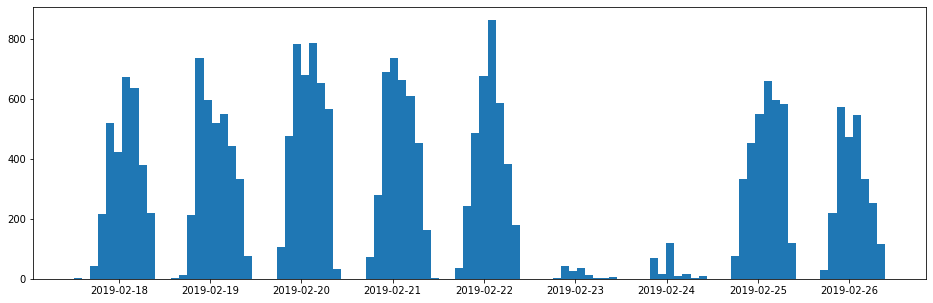

In [18]:
from datetime import timedelta

razlika = timedelta(hours=12)
_ = (vreme - razlika).hist(bins=100, grid=False, xlabelsize=10, ylabelsize=10, figsize=(16, 5))

Zgodno je svaki dan predstaviti histogramom i izračunati mu **osnovne parametre raspodele**. Za te potrebe, neophodno je vremenske oznake prevesti u realne brojeve, koji pritom čuvaju sve osobine vremena kao neprekidne sekvencijalne vrednosti. Realizacija uključuje klasu koja predstavlja dan, a čuva ime, kao i statistike poput broja događaja, srednje vrednosti, standardnog odstupanja, minimuma, maksimuma i kvantila (uključujući medijanu). Ona se, zarad preglednosti, dinamički popunjava u nastavku. Ništa ovo, međutim, nije moguće ako je ulazna serija datumskog tipa, pa se prvo mora pripremiti.

In [19]:
import matplotlib.pyplot as plt

imena = ['Ponedeljak (18. februar 2019)', 'Utorak (19. februar 2019)', 'Sreda (20. februar 2019)',
         'Četvrtak (21. februar 2019)', 'Petak (22. februar 2019)', 'Subota (23. februar 2019)',
         'Nedelja (24. februar 2019)', 'Ponedeljak (25. februar 2019)', 'Utorak (26. februar 2019)']

class Dan:
    ind = 0
    
    def __init__(self, ser, ime=None):
        self.ser = ser
        
        if ime is None:
            self.ime = imena[Dan.ind]
            self.i = Dan.ind
            Dan.ind += 1
        else:
            self.ime = ime
            self.i = None
        
        self.count = ser.count()
        
        self.mean = ser.mean()
        self.std = ser.std()
        
        self.min = ser.min()
        self.max = ser.max()
        
        self.q25 = ser.quantile(.25)
        self.q50 = ser.quantile(.5)
        self.q75 = ser.quantile(.75)
        self.iqr = self.q75 - self.q25
    
    def sređeno(self, broj):
        sat = int(broj)
        
        minut = broj - sat
        minut = round(60*minut)
        
        return f'{sat}:{minut:02d}'
    
    def meanf(self):
        return self.sređeno(self.mean)
    
    def stdf(self):
        return self.sređeno(self.std)
    
    def minf(self):
        return self.sređeno(self.min)
    
    def maxf(self):
        return self.sređeno(self.max)
    
    def q25f(self):
        return self.sređeno(self.q25)
    
    def q50f(self):
        return self.sređeno(self.q50)
    
    def q75f(self):
        return self.sređeno(self.q75)

Priprema, odnosno mapiranje datuma u realne brojeve, učinjena je na sledeći način: na nivou dana, ponoć tog dana predstavljena je nulom, a ponoć narednog brojem 24. Time se, primera radi, događaj od pet ujutru mapira baš u broj pet, dok se događaj od 6.45 mapira u 6,75 (punih šest sati i tri četvrtine minuta do sedmog). Vrednosti u seriji grupisane su po danu, pa je tako ona pretvorena u niz dana, koji pripadaju prethodno definisanoj klasi.

In [20]:
from datetime import datetime

dani = []

for dan, ser in vreme.groupby(lambda ind: vreme[ind].day):
    ponoć = datetime(2019, 2, dan)
    
    ser = ser.map(lambda dat: (dat - ponoć).total_seconds() / 3600)
    
    dani.append(Dan(ser))

Ovako pripremljeni dani mogu se lako ilustrovati. Svakom je pridružen histogram, na kom x-osa predstavlja sat, a y-osa broj događaja, dok su u legendi nabrojane različite važne statistike. Primetno je da je raspodela po danima, izuzev vikendom, vrlo slična:
* uglavnom preko tri hiljade događaja dnevno,
* najviše dešavanja je između 13h i 14h,
* standardno odstupanje je oko tri i po sata,
* prvi unos malo pre 6h, poslednji posle 21h,
* prva četvrtina aktivnosti desi se do 10–11h.
* poslednja četvrtina aktivnost je nakon 16–17h.

Vikendom se očitava znatno manje događaja (nekoliko stotina), pri čemu je početak kasnije, oko 8h, a tri četvrtine posla gotovo je već oko 13–14h.

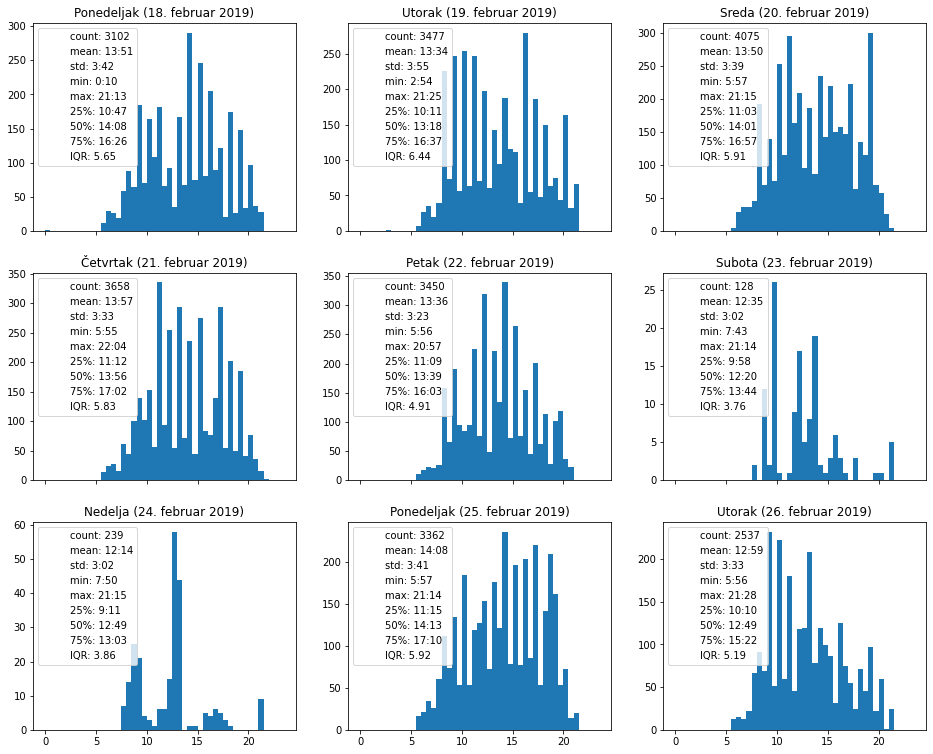

In [21]:
from itertools import product

def hist(dan, ax=None):
    if ax is None: ax = plt.gca()
    
    dan.ser.hist(ax=ax, bins=np.arange(0, 24, .5), grid=False)
    
    ax.plot([], [], ' ', label=f'count: {dan.count}')
    
    ax.plot([], [], ' ', label=f'mean: {dan.meanf()}')
    ax.plot([], [], ' ', label=f'std: {dan.stdf()}')
    
    ax.plot([], [], ' ', label=f'min: {dan.minf()}')
    ax.plot([], [], ' ', label=f'max: {dan.maxf()}')
    
    ax.plot([], [], ' ', label=f'25%: {dan.q25f()}')
    ax.plot([], [], ' ', label=f'50%: {dan.q50f()}')
    ax.plot([], [], ' ', label=f'75%: {dan.q75f()}')
    ax.plot([], [], ' ', label=f'IQR: {dan.iqr:.2f}')
    
    ax.set_title(dan.ime)
    ax.legend(loc='upper left')

Dan.hist = hist

inds = [*product(range(3), range(3))]
_, axs = plt.subplots(3, 3, figsize=(16, 13), sharex=True)

for i, dan in enumerate(dani):
    dan.hist(ax=axs[inds[i]])

## Elementi van granica

Među izračunatim podacima je i **interkvartilni raspon** (*IQR*). On je pogodan za otkrivanje **elemenata izvan granica (autlajera)**, dakle vrednosti koje se ne uklapaju u raspodelu, čak i kada je ona donekle nepravilna. Takav je slučaj ovde, pošto podaci definitivno ne izgledaju kao da dolaze iz neke poznate raspodele, a ipak izgledaju relativno zvonasto, sa pikom aktivnosti oko 13–14h i pravilnim kvantilima. Uopšteno, otkriveni autlajer lako može značiti otkrivenu sumnjivu aktivnost na sistemu, pošto se za takve događaje očekuje da narušavaju raspodelu. Prvo je prikazan pokazatelj nenormalnosti. Rezultat odlikuju visoke vrednosti test statistike, a izrazito male *p*-vrednosti testa, te prema značajnosti nema dovoljno razloga za prihvatanje pretpostavke o normalnosti.

In [22]:
from scipy.stats import normaltest

Dan.normal = lambda dan: normaltest(dan.ser)

for dan in dani:
    print(dan.normal())

NormaltestResult(statistic=342.0927830568444, pvalue=5.193929013519309e-75)
NormaltestResult(statistic=984.4993948737487, pvalue=1.6545225269516353e-214)
NormaltestResult(statistic=1042.6665436226654, pvalue=3.8711216547453785e-227)
NormaltestResult(statistic=438.5510689153212, pvalue=5.886340338103147e-96)
NormaltestResult(statistic=213.612286746606, pvalue=4.1179521854035515e-47)
NormaltestResult(statistic=20.647399941540403, pvalue=3.2845363295615496e-05)
NormaltestResult(statistic=29.163871113652498, pvalue=4.646713028865008e-07)
NormaltestResult(statistic=637.4683346187039, pvalue=3.7627896737800304e-139)
NormaltestResult(statistic=218.02059670352182, pvalue=4.543901989405472e-48)


Sada je u redu iskoristiti *IQR* kao najpoznatiji opšti statistički alat za otkrivanje elemenata van granica. Primetno je da su autlajerima proglašena na prvi pogled sasvim uredna očitavanja iz Jagićeve. Međutim, ona su se dogodila u kasnijim večernjim satima, još za vikend, kada je aktivnost razređena, pa može biti da je ovo korektna osobina subotnje i nedeljne raspodele, ili možda da je bio neki poseban događaj vezan za te dve večeri (večernja škola programiranja i slično). Ipak, na prvom mestu je uhvaćen jedat **i te kako sumnjiv** događaj, očitan deset minuta posle ponoći u sali 704, sa nepoznatim korisnikom kao pokretačem.

In [23]:
Dan.pre = lambda dan, vreme: dan.ser[dan.ser < vreme]
Dan.posle = lambda dan, vreme: dan.ser[dan.ser > vreme]

def iqr_autlajeri(dan):
    donji = dan.pre(dan.q25 - 1.5*dan.iqr)
    gornji = dan.posle(dan.q75 + 1.5*dan.iqr)
    
    return donji.append(gornji).index.to_numpy()

Dan.iqr_autlajeri = iqr_autlajeri

autlajeri = []
for dan in dani:
    autlajeri.extend(dan.iqr_autlajeri())

#spojeni.loc[autlajeri]

Vizuelni način predstavljanja prethodnog testa jesu **kutijasti dijagrami** (**kućice**, *boxplot*), na kojima su autlajeri prikazani kao kružići. Svi brojevi su prikazani na y-osi, dok x-osa služi za lepšu ilustraciju. Zelena horizontalna duž predstavlja medijanu (50% kvantil), vrh kutije je 75% kvantil, a dno 25%. Vertikalne linije koje izlaze iz kućice predstavljaju preostali raspon, a duži koje ih ograničavaju predstavljaju granicu, izvan koje su autlajeri, kao elementi van granica.

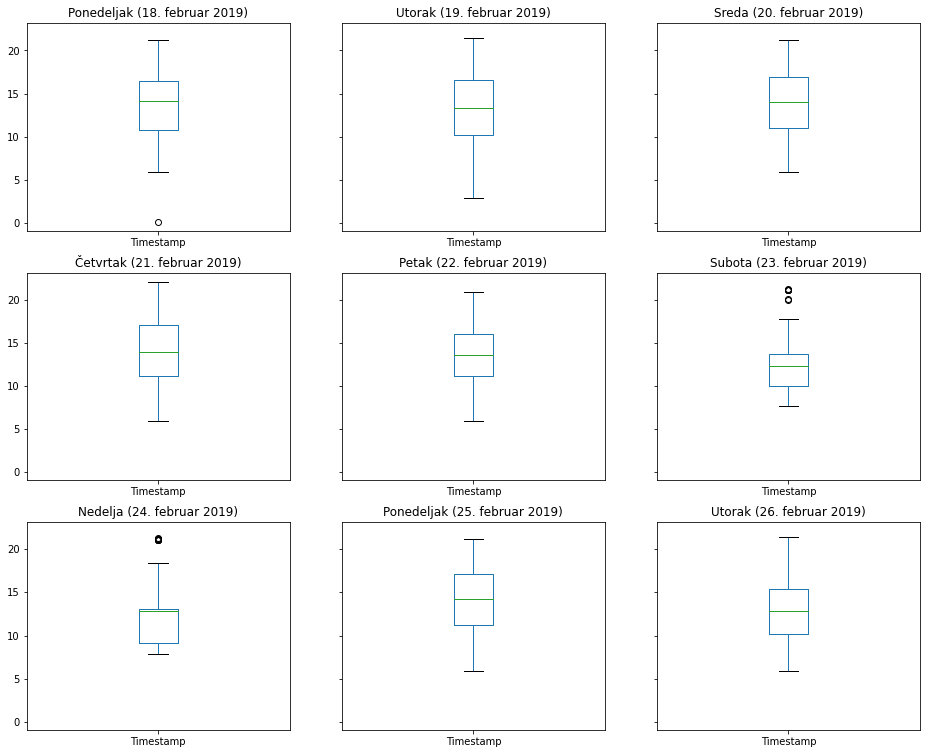

In [24]:
def box(dan, ax=None):
    if ax is None: ax = plt.gca()
        
    dan.ser.plot.box(ax=ax)
    
    ax.set_title(dan.ime)

Dan.box = box

_, axs = plt.subplots(3, 3, figsize=(16, 13), sharey=True)

for i, dan in enumerate(dani):
    dan.box(ax=axs[inds[i]])

Sličan statistički pristup podrazumeva određivanje elemenata van granica pomoću **z-skora**. Iako je u pitanju metod koji najbolje radi sa normalnom raspodelom, odnosno nije tolike opštosti kao *IQR*, ipak je u redu probati ga, pogotovu kada je raspodela centrirana oko srednje vrednosti. Ovaj pristup čak se možda čini boljim od prethodnog, pošto uspešno hvata sumnjivi posleponoćni događaj, ali ne hvata najverovatnije nesumnjive događaje iz Jagićeve.

In [25]:
def z_autlajeri(dan):
    donji = dan.pre(dan.mean - 3*dan.std)
    gornji = dan.posle(dan.mean + 3*dan.std)
    
    return donji.append(gornji).index.to_numpy()

Dan.z_autlajeri = z_autlajeri

autlajeri = []

for dan in dani:
    autlajeri.extend(dan.z_autlajeri())

spojeni.loc[autlajeri]

,Timestamp,User ID,User name,Access point ID,Access point name,Zone,Group name
0,2019-02-18 00:09:50,407896064,User unknown,9,PR402DRv2.16.1665/0009/8905_T1,704,NaN


Ostavivši statistiku po strani, a uzimajući u obzir **poznavanje domena**, moguće je osmisliti još prostiji test za određivanje sumnjivih događaja prema vremenu. Jednostavno, mogu se uhvatiti svi događaji npr. pre 5.55 i nakon 22h. Na ovaj način je većinski isključena najverovatnije lažno pozitivna kasnovečernja aktivnost u Jagićevoj vikendom, ali je uključen **još jedan kasnonoćni** neuobičajeni događaj od prvog utorka, za koji je malo verovatno da je stvarno u redu. Naime, oko tri sata posle ponoći došlo je do očitavanja u zbornici u Jagićevoj. Na istom mestu se nešto desilo i malo posle 22h, što bi se isto moglo proveriti.

In [26]:
def domen_autlajeri(dan):
    donji = dan.pre(5.9)
    gornji = dan.posle(22)
    
    return donji.append(gornji).index.to_numpy()

Dan.domen_autlajeri = domen_autlajeri

autlajeri = []

for dan in dani:
    autlajeri.extend(dan.domen_autlajeri())

spojeni.loc[autlajeri]

,Timestamp,User ID,User name,Access point ID,Access point name,Zone,Group name
0,2019-02-18 00:09:50,407896064,User unknown,9,PR402DRv2.16.1665/0009/8905_T1,704,NaN
3102,2019-02-19 02:54:20,268435456,NaN,300,PR402DRv1.18.06.1947/0300/049E***Zbornica,Jag_Zbornica,NaN
14311,2019-02-21 22:04:30,268435456,NaN,300,PR402DRv1.18.06.1947/0300/049E***Zbornica,Jag_Zbornica,NaN


## Lokalne anomalije

Naposletku, može se upotrebiti i neki napredniji metod za određivanje autlajera, kao što je **faktor lokalnih neobičnih vrednosti** (*LOF*). Ovaj metod je jedan od objektivno najuspešnijih na različitim vrstama podataka, a pritom se može koristiti i kao jednostavan sistem za sprečavanje upada. Naime, moguće je istrenirati ga nad čistim podacima, a nakon toga koristiti za otkrivanje novina (*novelty*) u test skupu koji se generiše uživo (*online*). Kako je pretpostavka da distribuirani podaci nisu čisti, ipak u nastavku neće biti ta primena, već ona uobičajena, za nalaženje elemenata van granica unutar (celog) trening skupa. Broj suseda 64 izabran je eksperimentalno, tako da nema ekstremnih vrednosti *LOF*-a, koje se mere u milijardama (već za 63 suseda) ili većim jedinicama.

In [27]:
from sklearn.neighbors import LocalOutlierFactor

def lof_autlajeri(dan, n=64):
    lof = LocalOutlierFactor(n)

    tren = dan.ser.to_numpy().reshape(-1, 1)
    dan.pred = lof.fit_predict(tren)

    dan.fact = lof.negative_outlier_factor_
    
    return dan.ser[dan.pred == -1].index.to_numpy()

Dan.lof_autlajeri = lof_autlajeri

autlajeri = []

for dan in dani:
    autlajeri.extend(dan.lof_autlajeri())

#spojeni.loc[autlajeri]

Rezultate je moguće fino i vizuelizovati. Tačke predstavljaju događaje, i to crvene ukoliko je događaj proglašen za element van granica, a plave inače. Na x-osi je predstavljeno vreme, dok y-osa pokazuje meru *LOF*-a; što je ona manja, to je element veći autlajer. Prikazi su skalirani na najraspršeniji (*sharex* i *sharey*). Primetan je veliki broj neuobičajenih aktivnosti prvog utorka oko pola osam ujutru, kao i prve srede oko podne, što će detaljnije biti ispitano u nastavku.

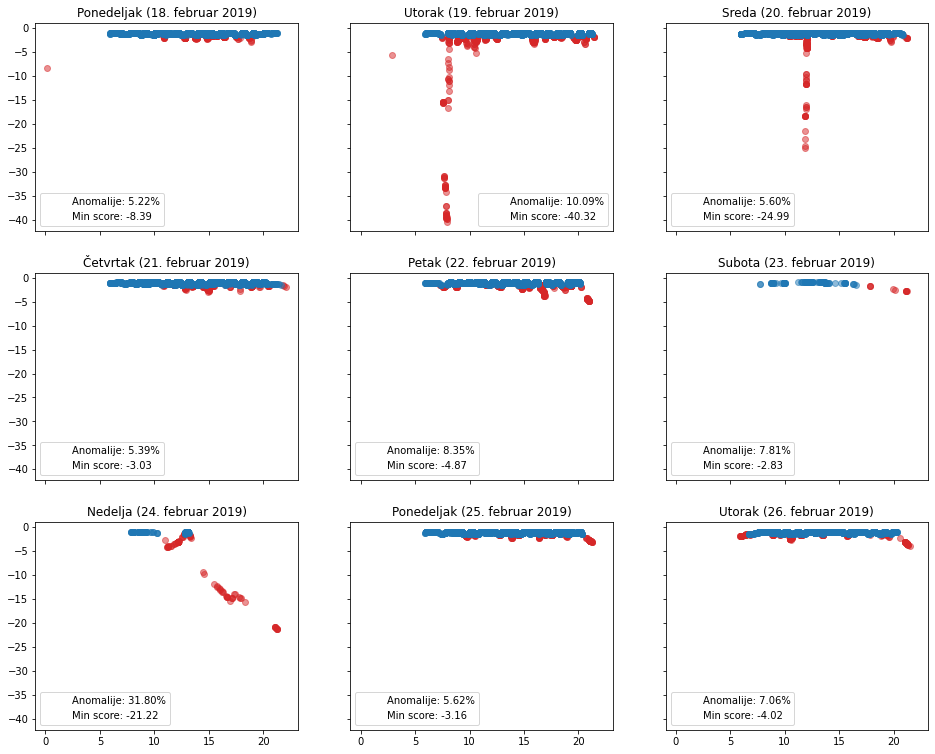

In [28]:
def lof(dan, ax=None):
    dan.lof_autlajeri()
    
    if ax is None: ax = plt.gca()
    
    ax.scatter(dan.ser[dan.pred == -1],
               dan.fact[dan.pred == -1],
               color='tab:red', alpha=.5)
    
    ax.scatter(dan.ser[dan.pred == 1],
               dan.fact[dan.pred == 1],
               color='tab:blue', alpha=.5)
    
    udeo = sum(dan.pred == -1) / len(dan.pred) * 100
    ax.plot([], [], ' ', label=f'Anomalije: {udeo:.2f}%')
    ax.plot([], [], ' ', label=f'Min score: {dan.fact.min():.2f}')
    
    ax.set_title(dan.ime)
    ax.legend(loc='lower right' if dan.i in [None, 1] else 'lower left')

Dan.lof = lof

_, axs = plt.subplots(3, 3, figsize=(16, 13), sharex=True, sharey=True)

for i, dan in enumerate(dani):
    dan.lof(ax=axs[inds[i]])

Glavna mana ovog pristupa je veliki broj **lažno pozitivnih** rezultata, pa je tako čak 1680 događaja proglašeno anomalijom. Ovo se može ublažiti uzimanjem nešto većeg praga odstupanja kao značajnog, umesto podrazumevanih -1,5. U nastavku je to i učinjeno, što je osetno isfiltriralo izveštaj. Sa grafika je zaključeno da bi -5 mogao biti dobar broj, pa se sada registruje samo 115 sumnjivih unosa, koji se već i ručno mogu analizirati i proveriti.

Ovaj pristup liči na prethodne utoliko što je:
* uspešno uhvatio dva noćna događaja, kao i
* nedeljnu aktivnost Birmazović Anđelke u Jagićevoj,

ali se razlikuje po tome što je:
* zanemario subotnju aktivnost Mišić Slobodanke,
* **uhvatio dosta aktivnosti drugog i trećeg dana**.

Štaviše, nema potrebe ponavljati već otkrivene potencijalne probleme, pa je izdvojeno samo ono što je novo. Nakon odbacivanja starih sumnji, očitavanja je ukupno 78. Najmanji faktor lokalnih neobičnih vrednosti imaju dešavanja u **utorak, 19. februara, od 7.40 do 7.50 u *Akvarijumu***, a algoritmu konkretno najviše zapada za oko aktivnost administratora **JP Smith Son**. Postoje i veći klasteri odudarajućih događaja u salama 704 (isti dan) i 718 (sutradan). Prva sala bi mogla biti posebno zanimljiva, pošto je upravo u njoj dan pre ovog klastera došlo do statistički sumnjivog očitavanja nešto posle ponoći.

In [29]:
def lof_aut_thresh(dan, thresh=-1.5):
    dan.lof_autlajeri()
    
    ser = dan.ser[dan.fact < thresh].index.to_numpy()
    fact = dan.fact[dan.fact < thresh]
    
    return ser, fact

Dan.lof_aut_thresh = lof_aut_thresh

autlajeri = []
lofovi = []

for dan in dani:
    ser, fact = dan.lof_aut_thresh(-5)
    autlajeri.extend(ser)
    lofovi.extend(fact)

problemi = spojeni.loc[autlajeri]
problemi['LOF'] = lofovi

utosre = lambda time: time.day in (19, 20)
problemi = problemi[problemi.Timestamp.map(utosre)]
problemi.drop(3102, inplace=True)

problemi.sort_values(by='LOF', inplace=True)

#with pd.option_context('display.max_rows', None):
#    display(problemi.drop(columns=['User ID', 'Access point ID']))

## Saglasnost raspodela

Kao poslednji skup razmatranja, mogla bi se proveriti **jednakost raspodela aktivnosti u toku dana**. Po svemu sudeći, manja datoteka predstavlja normalne okolnosti na sistemu, dok se u većoj događa štošta sumnjivo. U dosadašnjim rezultatima su isključivo u većoj otkriveni razni problemi, od nesaglasnih podataka do elemenata van granica. Stoga bi nad podacima iz manje datoteke mogao biti napravljen *LOF* sa uključenim *novelty* parametrom. Time se, kako je već napomenuto, dobija jednostavan sistem za sprečavanje upada, koji se može testirati nad sumnjivom velikom datotekom. Prvo se spajaju dva 'dobra' dana.

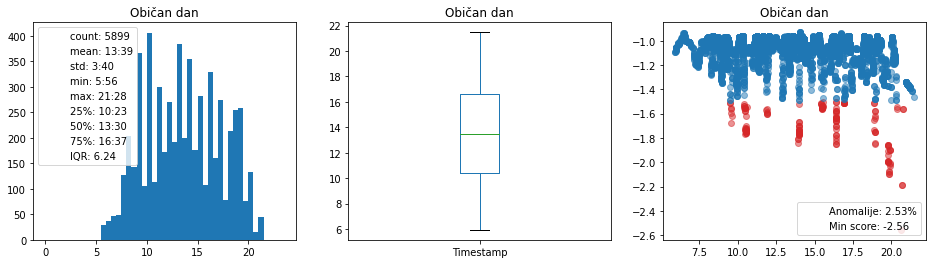

In [30]:
def spoj(dan, oth, ime='Običan dan'):
    return Dan(dan.ser.append(oth.ser), ime)

Dan.spoj = spoj

def ilustruj(dan):
    _, axs = plt.subplots(1, 3, figsize=(16, 4))
    
    dan.hist(axs[0])
    dan.box(axs[1])
    dan.lof(axs[2])

Dan.ilustruj = ilustruj

dan = dani[-2].spoj(dani[-1])
dan.ilustruj()

Sada se pravi *novelty LOF*. Broj suseda ostaje kao i u prethodnim razmatranjima. Proverom treniranih vrednosti, utvrđuje se da je otprilike -2.5 granica skora očitavanja koje je deo očekivanih, uobičajenih događaja, dok model to pamti kao minimum i buduću granicu (*threshold*) uobičajenosti.

In [31]:
def ids_autlajeri(dan, oth):
    ids = LocalOutlierFactor(64, novelty=True)
    
    tren = dan.ser.to_numpy().reshape(-1, 1)
    ids.fit(tren)
    
    thresh = ids.score_samples(tren).min()
    
    test = oth.ser.to_numpy().reshape(-1, 1)
    fact = ids.score_samples(test)
    
    ser = oth.ser[fact < thresh].index.to_numpy()
    fact = fact[fact < thresh]
    
    return ser, fact

Dan.ids_autlajeri = ids_autlajeri

Na kraju se model testira nad odgovarajuća dva 'loša' dana. Sami rezultati, međutim, ne otkrivaju ništa novo. I dalje su najsumnjiviji kasnonoćni događaji, mada su se pojavila još dva zanimljiva iz *Arhiva* u Jagićevoj. Primetno je da je više anomalija otkriveno u neobičnom utorku, dok je ponedeljak saglasan.

In [32]:
autlajeri = []
lofovi = []

for oth in dani[:2]:
    ser, fact = dan.ids_autlajeri(oth)
    autlajeri.extend(ser)
    lofovi.extend(fact)

problemi = spojeni.loc[autlajeri]
problemi['LOF'] = lofovi

problemi.sort_values(by='LOF')

,Timestamp,User ID,User name,Access point ID,Access point name,Zone,Group name,LOF
0,2019-02-18 00:09:50,407896064,User unknown,9,PR402DRv2.16.1665/0009/8905_T1,704,NaN,-14.525733
3102,2019-02-19 02:54:20,268435456,NaN,300,PR402DRv1.18.06.1947/0300/049E***Zbornica,Jag_Zbornica,NaN,-7.857359
6482,2019-02-19 20:35:30,536870914,Controller input 2,309,PR402DRv1.18.06.1947/0309/9509***Arhiva,Jag_Arh,NaN,-2.743674
6481,2019-02-19 20:35:10,138,Milisav Mara�,1309,PR402DRv1.18.06.1947/0309/9509_T0,Jag_Arh,Slavisa,-2.715269


Nije loša ideja ni statistički proveriti međusobnu saglasnost raspodela u paru. Ovo se može uraditi npr. na sledeća tri načina:
* **$\chi^2$ test nezavisnosti** – smatra se da su vremena diskretno (kategorički) raspodeljena po satima i proverava se jesu li nezavisna,
* **Kolmogorov-Smirnov test** – smatra se da su vremema događaja neprekidno raspodeljena i proverava se potiču li iz iste raspodele,
* **Eps-Singltonov test** – ne uzima se u obzir (nije važno) kako su vremena raspodeljena i proverava se potiču li iz iste raspodele.

S jedne strane, imalo bi logike da su raspodele saglasne. S druge, svaki dan je drugačiji, pa je možda i veća verovatnoća da nisu.

In [33]:
from scipy.stats import chi2_contingency, ks_2samp, epps_singleton_2samp

Prvi korak $\chi^2$ testa nezavisnosti jeste pravljenje tablice kontingencija, odnosno tabeliranje događaja po danima i satima.

In [34]:
Dan.sati = lambda dan: dan.ser.map(int)

conting = np.zeros((9, 24), dtype=np.int64)

for i, dan in enumerate(dani):
    for j in dan.sati():
        conting[i, j] += 1

with pd.option_context('display.max_columns', None):
    display(pd.DataFrame(conting, index=range(18, 27),
                         columns=[f'{i}-{i+1}' for i in range(24)]))

,0-1,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-24
18,1,0,0,0,0,12,56,77,152,254,273,247,127,235,364,326,295,141,201,181,132,28,0,0
19,0,0,1,0,0,7,62,60,299,302,317,318,258,237,302,151,334,234,214,119,196,66,0,0
20,0,0,0,0,0,4,64,82,262,216,368,460,304,273,377,369,304,285,250,370,82,5,0,0
21,0,0,0,0,0,15,52,78,144,243,209,429,309,366,280,359,216,347,252,226,113,19,1,0
22,0,0,0,0,0,11,40,48,225,284,179,301,368,356,411,341,200,264,142,220,60,0,0,0
23,0,0,0,0,0,0,0,2,12,28,1,10,22,27,3,9,4,3,0,1,1,5,0,0
24,0,0,0,0,0,0,0,7,39,25,4,12,73,44,2,5,10,8,1,0,0,9,0,0
25,0,0,0,0,0,16,55,87,186,188,237,246,225,297,314,273,290,274,351,216,87,20,0,0
26,0,0,0,0,0,13,28,89,160,283,282,226,237,286,218,117,200,79,116,119,60,24,0,0


Testiranjem nezavisnosti, pre čega su filtrirane nula kolone, dobijaju se male značajnosti testa. Jedino za vikend ima razloga prihvatiti ideju da su subota i nedelja nezavisne, što bi se moglo protumačiti kao da potiču iz iste raspodele, mada i to tek sa niskom značajnošću, oko $10^{-3}$.

In [35]:
def chi2_test(i, j):
    tabela = conting[[i, j]]
    
    cols = [col for col in range(24) if tabela[0, col] == 0 and tabela[1, col] == 0]
    
    tabela = np.delete(tabela, cols, 1)
    
    chi2_rez = chi2_contingency(tabela)
    
    return chi2_rez[1]

chi2 = np.full((9, 9), 1.)

inds = [(i, j) for i in range(9) for j in range(i+1, 9)]

for i, j in inds:
    chi2[i, j] = chi2_test(i, j)
    chi2[j, i] = chi2[i, j]

chi2 = pd.DataFrame(chi2, index=range(18, 27), columns=range(18, 27))

with pd.option_context('display.float_format', '{:.0e}'.format):
    display(chi2)

,18,19,20,21,22,23,24,25,26
18,1e+00,7e-39,6e-36,4e-42,2e-54,6e-26,3e-88,7e-23,1e-39
19,7e-39,1e+00,6e-64,6e-64,2e-76,1e-17,3e-50,2e-45,4e-32
20,6e-36,6e-64,1e+00,4e-26,5e-33,2e-40,3e-79,1e-23,8e-58
21,4e-42,6e-64,4e-26,1e+00,5e-25,6e-21,9e-61,9e-19,2e-56
22,2e-54,2e-76,5e-33,5e-25,1e+00,3e-37,4e-62,4e-42,8e-52
23,6e-26,1e-17,2e-40,6e-21,3e-37,1e+00,7e-03,3e-26,2e-10
24,3e-88,3e-50,3e-79,9e-61,4e-62,7e-03,1e+00,9e-66,1e-37
25,7e-23,2e-45,1e-23,9e-19,4e-42,3e-26,9e-66,1e+00,2e-50
26,1e-39,4e-32,8e-58,2e-56,8e-52,2e-10,1e-37,2e-50,1e+00


Ni Kolmogorov-Smirnov test nije uspešno utvrdio statistički značajnu vezu između raspodela događaja po danima. Prema njemu, najviše izgleda da potiču iz iste raspodele imaju ponedeljak, 18. februar, i sreda, 20. februar, ali i ovoga puta tek sa niskom značajnošću, oko $10^{-3}$.

In [36]:
def ks_test(i, j):
    ks_rez = ks_2samp(dani[i].ser, dani[j].ser)
    
    return ks_rez[1]

ks = np.full((9, 9), 1.)

for i, j in inds:
    ks[i, j] = ks_test(i, j)
    ks[j, i] = ks[i, j]

ks = pd.DataFrame(ks, index=range(18, 27), columns=range(18, 27))

with pd.option_context('display.float_format', '{:.0e}'.format):
    display(ks)

,18,19,20,21,22,23,24,25,26
18,1e+00,9e-10,1e-03,3e-07,2e-08,3e-13,5e-15,3e-07,4e-39
19,9e-10,1e+00,4e-10,1e-18,2e-12,4e-08,7e-16,1e-18,2e-14
20,1e-03,4e-10,1e+00,3e-04,2e-11,1e-10,2e-16,4e-08,6e-28
21,3e-07,1e-18,3e-04,1e+00,2e-12,5e-10,2e-15,8e-08,2e-15
22,2e-08,2e-12,2e-11,2e-12,1e+00,1e-08,9e-16,3e-21,8e-16
23,3e-13,4e-08,1e-10,5e-10,1e-08,1e+00,1e-04,2e-13,2e-03
24,5e-15,7e-16,2e-16,2e-15,9e-16,1e-04,1e+00,7e-16,5e-16
25,3e-07,1e-18,4e-08,8e-08,3e-21,2e-13,7e-16,1e+00,8e-16
26,4e-39,2e-14,6e-28,2e-15,8e-16,2e-03,5e-16,8e-16,1e+00


Eps-Singltonov test je obuhvatio rezultate prethodna dva (povezani vikend i ponedeljak sa sredom), ali nije uspeo da zaključi ništa posebno novo. Ipak, izdvaja se po tome što dovodi u vezu ponedeljak, 18. februar, sa četvrtkom, 22. februarom, mada isto sa niskom značajnošću od oko $10^{-3}$.

In [37]:
def es_test(dani, i, j):
    es_rez = epps_singleton_2samp(dani[i].ser, dani[j].ser)
    
    return es_rez[1]

es = np.full((9, 9), 1.)

for i, j in inds:
    es[i, j] = es_test(dani, i, j)
    es[j, i] = es[i, j]

es = pd.DataFrame(es, index=range(18, 27), columns=range(18, 27))

with pd.option_context('display.float_format', '{:.0e}'.format):
    display(es)

,18,19,20,21,22,23,24,25,26
18,1e+00,7e-11,1e-03,2e-03,4e-10,5e-22,3e-39,2e-06,8e-24
19,7e-11,1e+00,2e-15,3e-20,2e-30,2e-19,4e-33,3e-26,1e-14
20,1e-03,2e-15,1e+00,4e-05,1e-13,2e-23,4e-46,6e-06,5e-25
21,2e-03,3e-20,4e-05,1e+00,6e-07,4e-20,1e-41,7e-10,4e-26
22,4e-10,2e-30,1e-13,6e-07,1e+00,4e-14,3e-28,3e-23,4e-19
23,5e-22,2e-19,2e-23,4e-20,4e-14,1e+00,2e-02,8e-32,4e-09
24,3e-39,4e-33,4e-46,1e-41,3e-28,2e-02,1e+00,9e-59,5e-15
25,2e-06,3e-26,6e-06,7e-10,3e-23,8e-32,9e-59,1e+00,6e-47
26,8e-24,1e-14,5e-25,4e-26,4e-19,4e-09,5e-15,6e-47,1e+00


## Regresioni modeli

Sledeći primenjeni metod jesu **Grejndžerovi testovi uzročnosti (kauzalnosti)**. U pitanju je skup od četiri testa, specijalizovana za proveru da li jedna vremenska serija zavisi od druge, pri čemu je nulta hipoteza da druga ne utiče na prvu utoliko što ne postoji statistička veza između ranijih vrednosti druge i trenutne vrednosti prve, mada se uzimaju u obzir i ranije vrednosti prve. Najčešća upotreba im je u finansijama, ali nema razloga da se ne primene i u kontroli pristupa. Ovde su primenjeni na tablicu kontingencija, jer je ona jedina koja tačno raspoređuje događaje po satima kao diskretnim vremenskim odrednicama. Jednostavnosti radi, uprosečene su *p*-vrednosti svih testova, po svakom parametru. Nije proveravan uticaj unazad, pa su takve ćelije popunjene *NaN* (*not a number*) vrednostima. Ni ovoga puta se nije došlo do statistički značajnih saznanja. Ovo je, inače, primer regresije, ali i **autoregresije**.

In [38]:
from statsmodels.tsa.stattools import grangercausalitytests

def gr_test(i, j, n=7):
    serije = conting[[i, j]].reshape(-1, 2)
    
    p = []
    
    rez = grangercausalitytests(serije, n, verbose=False)
    
    for _, val in rez.items():
        for _, val in val[0].items():
            p.append(val[1])
    
    return np.mean(p)

gr = np.full((9, 9), 0.)

for i, j in inds:
    gr[i, j] = np.nan
    gr[j, i] = gr_test(j, i)

gr = pd.DataFrame(gr, index=range(18, 27), columns=range(18, 27))

with pd.option_context('display.float_format', '{:.0e}'.format):
    display(gr)

,18,19,20,21,22,23,24,25,26
18,0e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,2e-01,0e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,3e-01,3e-01,0e+00,NaN,NaN,NaN,NaN,NaN,NaN
21,3e-01,2e-01,3e-01,0e+00,NaN,NaN,NaN,NaN,NaN
22,2e-01,3e-01,3e-01,1e-01,0e+00,NaN,NaN,NaN,NaN
23,1e-02,2e-01,4e-02,6e-02,6e-02,0e+00,NaN,NaN,NaN
24,1e-02,2e-01,3e-01,5e-02,8e-02,5e-01,0e+00,NaN,NaN
25,3e-02,3e-01,5e-01,2e-01,2e-01,5e-03,9e-03,0e+00,NaN
26,5e-02,4e-01,5e-01,3e-02,2e-01,5e-02,1e-01,5e-02,0e+00


Na poslednjem mestu u nizu pokušaja nalazi se **(nelinearna) regresija**. Iako, po svemu sudeći, pretpostavka da su događaji slično raspodeljeni kroz dane nema statistički značaj, nije loše umesto odustajanja probati dodatne metode. Konkretno je primenjem **regresor zasnovan na potpornim vektorima** (*SVR*). Regresor sa polinomijalnim kernelom treniran je nad svakim pojedinačnim danom, a ideja je proveriti koliko rezultujuće krive liče jedna na drugu. I liče, mada valja primetiti da su dani unutar sebe vrlo varijabilni i teški za procenu, što je prouzrokovalo da apsolutno svaka od ulazne 24 vrednosti bude potporni vektor.

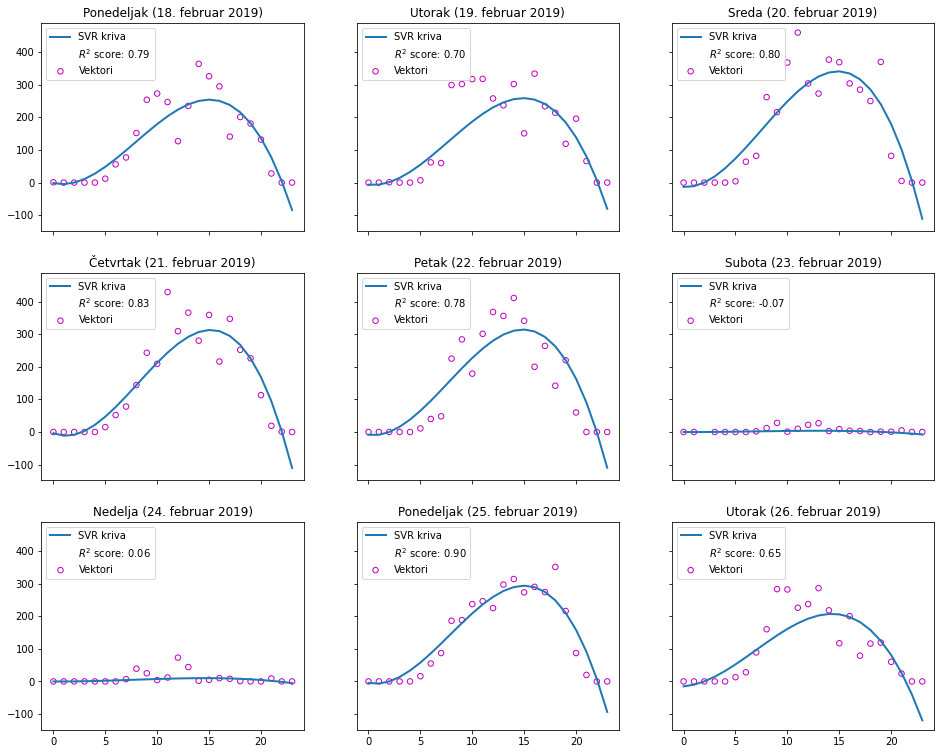

In [39]:
from sklearn.svm import SVR

def cont(ser):
    tab = np.zeros(24)
    
    for i in ser:
        tab[int(i)] += 1
    
    return tab

def svr(dan, ax=None):
    if ax is None: ax = plt.gca()
    
    X = np.arange(24).reshape(-1, 1)
    y = cont(dan.ser) if dan.i is None else conting[dan.i]
    
    svr = SVR(kernel='poly', gamma='auto', degree=3, coef0=1)
    y_pred = svr.fit(X, y).predict(X)
    
    ax.plot(X, y_pred, lw=2, label='SVR kriva')
    ax.scatter(X[svr.support_], y[svr.support_],
               c='none', edgecolors='m', s=30, label='Vektori')
    
    ax.plot([], [], ' ', label=f'$R^2$ score: {svr.score(X, y):.2f}')
    
    ax.set_title(dan.ime)
    ax.legend(loc='upper left')
    
    return y_pred

Dan.svr = svr

inds = [*product(range(3), range(3))]
_, axs = plt.subplots(3, 3, figsize=(16, 13), sharex=True, sharey=True)

y_pred = []

for i, dan in enumerate(dani):
    y_pred.append(dan.svr(ax=axs[inds[i]]))

Sada se čini da ima logike proveriti poklapanje raspodela koje generišu rezultujuće krive ukoliko bi se posmatrale kao, doduše nenormalizovane (površina ispod njih nije jedan), gustine raspodela. Ovoga puta se jasno primećuje da radni dani pripadaju jednoj povezanoj grupi, a vikend drugoj.

In [40]:
es = np.full((9, 9), 1.)

inds = [(i, j) for i in range(9) for j in range(i+1, 9)]

for i, j in inds:
    es[i, j] = epps_singleton_2samp(y_pred[i], y_pred[j])[1]
    es[j, i] = es[i, j]

es = pd.DataFrame(es, index=range(18, 27), columns=range(18, 27))

with pd.option_context('display.float_format', '{:.0e}'.format):
    display(es)

,18,19,20,21,22,23,24,25,26
18,1e+00,1e+00,1e-01,2e-01,2e-01,3e-12,5e-11,3e-01,2e-01
19,1e+00,1e+00,1e-01,2e-01,2e-01,1e-12,1e-11,4e-01,2e-01
20,1e-01,1e-01,1e+00,7e-01,7e-01,2e-12,1e-11,3e-01,3e-02
21,2e-01,2e-01,7e-01,1e+00,1e+00,2e-10,1e-09,8e-01,6e-02
22,2e-01,2e-01,7e-01,1e+00,1e+00,4e-12,3e-11,8e-01,5e-02
23,3e-12,1e-12,2e-12,2e-10,4e-12,1e+00,1e-03,2e-12,1e-09
24,5e-11,1e-11,1e-11,1e-09,3e-11,1e-03,1e+00,2e-11,7e-09
25,3e-01,4e-01,3e-01,8e-01,8e-01,2e-12,2e-11,1e+00,8e-02
26,2e-01,2e-01,3e-02,6e-02,5e-02,1e-09,7e-09,8e-02,1e+00


Sličan rezultat može se dobiti i bez modela. Ispostavlja se da je dovoljno testirati redove tablice kontingencija. Ovo dovodi do zaključka da, iako se ne može reći da su raspodele događaja po danima jednake po frekvenciji, one ipak jesu jednake po trendu. Svaki radni dan lagano počinje (uspon nije strm), a onda se malo manje lagano (pad je strmlji) završava. Šablon neodoljivo podseća na **gama raspodelu**, ali ipak nije, jer je kod nje trend obrnut: nagli rast, pa lagani pad.

In [41]:
es = np.full((9, 9), 1.)

for i, j in inds:
    es[i, j] = epps_singleton_2samp(conting[i], conting[j])[1]
    es[j, i] = es[i, j]

es = pd.DataFrame(es, index=range(18, 27), columns=range(18, 27))

with pd.option_context('display.float_format', '{:.0e}'.format):
    display(es)

,18,19,20,21,22,23,24,25,26
18,1e+00,8e-01,3e-01,8e-01,8e-01,1e-05,9e-05,8e-01,8e-01
19,8e-01,1e+00,5e-01,8e-01,7e-01,6e-06,4e-05,1e+00,4e-01
20,3e-01,5e-01,1e+00,9e-01,9e-01,5e-05,2e-04,4e-01,5e-02
21,8e-01,8e-01,9e-01,1e+00,1e+00,2e-05,2e-04,8e-01,4e-01
22,8e-01,7e-01,9e-01,1e+00,1e+00,1e-04,7e-04,7e-01,4e-01
23,1e-05,6e-06,5e-05,2e-05,1e-04,1e+00,6e-01,2e-05,4e-05
24,9e-05,4e-05,2e-04,2e-04,7e-04,6e-01,1e+00,1e-04,5e-04
25,8e-01,1e+00,4e-01,8e-01,7e-01,2e-05,1e-04,1e+00,6e-01
26,8e-01,4e-01,5e-02,4e-01,4e-01,4e-05,5e-04,6e-01,1e+00


## Dodatne ideje

Jedna od dodatnih ideja za proveru korektnosti očitavanja jeste **provera aktivnosti po svakom korisniku**, odnosno **po svakoj pristupnoj tački**. Sve što je prethodno rađeno na celom skupu događaja, moglo bi se odraditi na skupu filtriranom po identifikatoru korisnika i/ili pristupne tačke. Time bi se dobila uslovna raspodela događaja pri korisniku, odnosno tački, pa bi se npr. elementi van granica mogli računati za svakog pojedinačno, kao i za svaki par. Ipak, ovakav pristup zahtevao bi mnogo manje nedostajućih vrednosti kako bi imao smisla. Sa njima, svako može biti anoniman i time zamaskirati svoju raspodelu.

Za pristupne tačke je već realnije sprovesti ga, a u nastavku je dat kratak primer sa očitavanjima iz *Akvarijuma*. Iako nijedan događaj nije element van granica prema *IQR* metodi, histogram i *LOF* ukazuju na nekoliko potencijalnih nepravilnosti. *LOF* hvata nalete aktivnosti iz velike datoteke (drugi i treći crveni vertikalni 'stubić' tačaka), slično kao i pre ograničavanja na *Akvarijum*, ali on i histogram imaju dodatne sumnje, koje nisu mogle biti primećene onda kada je analizirana celokupna vremenska serija. Naime, jasno prikazuju retku izolovanu aktivnost rano ujutru (izdvojeni levi deo na histogramu i prvi 'stubić' tačaka na *LOF*-u).

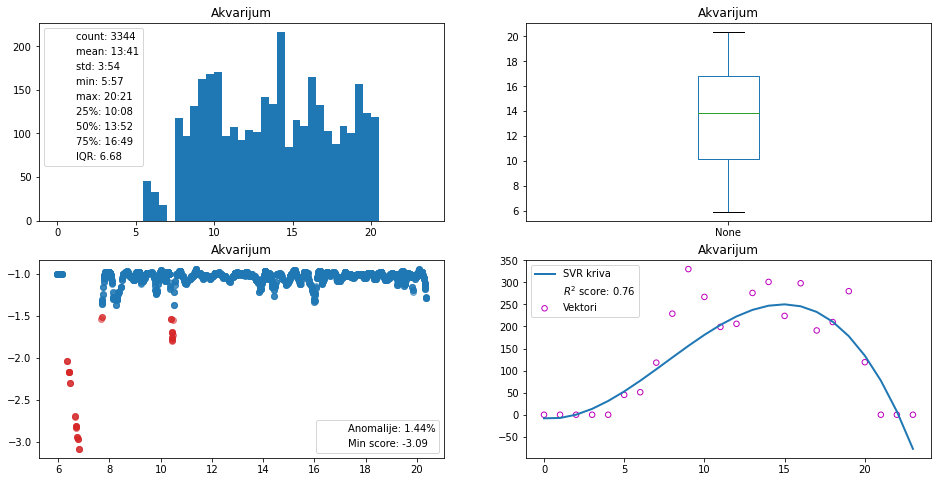

In [42]:
def ilustruj(dan):
    _, axs = plt.subplots(2, 2, figsize=(16, 8))
    
    dan.hist(axs[0, 0])
    dan.box(axs[0, 1])
    dan.lof(axs[1, 0])
    dan.svr(axs[1, 1])

Dan.ilustruj = ilustruj

akvarijum = spojeni[spojeni['Zone'] == 'Akvarijum']['Timestamp']

serija = pd.Series(dtype=np.float64)

for dan, ser in akvarijum.groupby(lambda ind: akvarijum[ind].day):
    ponoć = datetime(2019, 2, dan)
    
    ser = ser.map(lambda dat: (dat - ponoć).total_seconds() / 3600)
    
    serija = serija.append(ser)

dan = Dan(serija, 'Akvarijum')
dan.ilustruj()

Takođe se može proveravati i **saglasnost očitavanja**. Primera radi, nije moguće teleportovati se, pa tako npr. aktivnost u 10h na Trgu, praćena aktivnošću u 10.10 u Jagićevoj, ne zvuči realno, tj. nije izvodljiva u stvarnosti bez neke manipulacije. Ovakvih problema, međutim, nema u obrađenom skupu. Slično bi se moglo meriti i za ostale uređaje, jer npr. nije moguće za minut stići od Dekanata do DLAB-a. Ovo bi se moglo postići matricom vremenskih rastojanja.

In [43]:
def teleportovanje(df):
    mapa = {}
    tel = False
    
    for ind, unos in df.iterrows():
        user = unos['User ID']
        if user > 500: continue
        
        time = unos['Timestamp']
        jag = unos['Zone'].startswith('Jag')
        
        if user in mapa:
            old = mapa[user]['time']
            secs = (time - old).total_seconds()
            mins = secs / 60
            
            if jag != mapa[user]['jag'] and mins < 10:
                tel = True
                
                print('Teleportovanje!')
                print(f'Prethodno: {user} \u2192 {not jag} ({old})')
                print(f'Sada ({ind}): {user} \u2192 {jag} ({time})')
                
                mapa[user]['time'] = time
                mapa[user]['jag'] = jag
        else:
            mapa[user] = {'time': time, 'jag': jag}
    
    return tel

teleportovanje(spojeni)

False

## Zaključak

Što se tiče opisne analize, proverom **funkcionalnih zavisnosti** utvrđena je **veza između atributa** i naznačena su tri nezavisna – vremenska oznaka, ID korisnika, ID pristupne tačke. Primećena je veza između korisnika i tačaka – isti korisnici često pristupaju istim lokacijama. Detaljno je ispitana **raspodela događaja** u toku dana, za svaki posebno. **Provera saglasnosti** nije dala značajne rezultate, dok je **regresija** pomogla u razumevanju i upoređivanju. Prilikom uvodnog pregleda podataka, izvršena je i analiza **frekvencije**, a prokomentarisane su i **nedostajuće vrednosti**, kao i mnogi drugi detalji o skupu. Sve je potkrepljeno mnogobrojnim **statistikama** i **ilustracijama** – saćem, histogramima, kutijastim dijagramima, graficima sa razbacanim elementima, krivama.

Kada je u pitanju uporedna analiza, primenjeno je nekoliko tehnika za otkrivanje **elemenata van granica (autlajera)**, kao i nešto naprednija tehnika otkrivanja **lokalnih anomalija**. Napravljen je čak i jedan **diskriminativni model** zasnovan na *LOF*-u, a izneto je i nekoliko dodatnih ideja za pravljenje robusnijeg sigurnosnog sistema. **Statistički testovi** nisu dali rezultate. Sveukupno je **uspešno je pronađeno nekoliko sumnjivih unosa u većoj datoteci**:
* korisnik sa ID-jem 171, koji je uglavnom Pajić Vojislav, ali je jednom Janko Janković,
* prvog dana očitavanje iz 704 nekoliko minuta posle ponoći, bez poznatog korisnika,
* drugog dana očitavanje iz zbornice u Jagićevoj oko tri unoć, sa nedostajućim korisnikom,
* drugog i trećeg dana nalet aktivnosti u 7–8h, odnosno 12h, koje nisu lokalno saglasne.

Kada je statistika u pitanju, važno je još napomenuti da se možda neka stvarno zanimljiva aktivnost nije pokazala **statistički značajnom**, dok su s druge strane neke koje su sasvim u redu bile obeležene. Stoga često ipak nije dovoljno primenjivati uobičajene metode, poput onih iz prethodnog teskta, već je verovatno sigurnije, pa i isplativije koristiti neki razrađeni **sistem za sprečavanje upada** (*IDS*). Primera radi, mogao bi se koristiti neki od dostupnog sigurnosnog softvera, pa čak i **veštački imunski sistem** (*AIS*), koji je u stanju da uživo (*online*) otkriva neobična dešavanja, kao prirodni imunitet.